# Hyper-Parameters
1. Wavelet
2. Peak height
3. Peak width

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from pprint import pprint as pp
from pyarrow import parquet as pq
import pywt
from scipy import signal as dsp
import seaborn as sns
from sklearn.externals import joblib
import yaml

from utils import load_data

sns.set()

In [2]:
with open('../config.yaml', 'r') as f:
    cfg = yaml.load(f)

DATA_DIR = '../data'
test_start = 8712  # TODO: What is this?

In [3]:
train_gen = load_data('train', cfg.get('num_lines'))
train, meta_train = next(train_gen)
test_gen = load_data('test', cfg.get('num_lines'))
test, meta_test = next(test_gen)

Text(0.5, 0.98, 'Training Examples: 0 [5, 5, 6]')

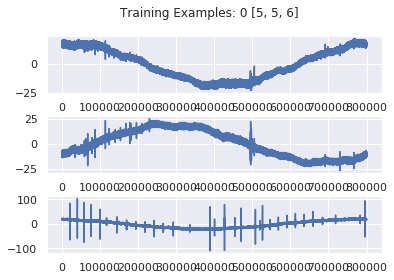

In [4]:
idx = np.random.randint((train.shape[0] / 3) + 1,)

fig, ax = plt.subplots(3, 1, sharex='col')
measurements = list()
for count in range(3):
    plt.subplot(((count + 1) * 1) + 310)
    plt.plot(train[idx + count])
    measurements.append(meta_train.iloc[idx + count].id_measurement)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
plt.suptitle("Training Examples: {} {}".format(meta_train.iloc[idx + count].target,
                                               measurements))

PD: 0


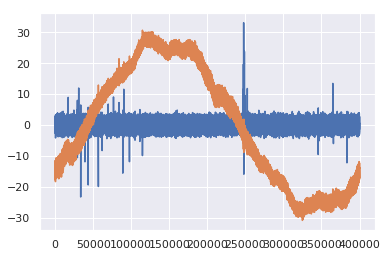

In [5]:
# Subscripts refer to the phase number, 1-3
sig_0, sig_1, sig_2 = train[idx + 1: idx + 4]
target = meta_train.iloc[idx + 1].target
print("PD: {}".format(meta_train.iloc[idx + 1].target))

wavelet = cfg.get('mother_wavelet')
level = cfg.get('decomposition_level')

cA_0, *cDx_0 = pywt.wavedec(sig_0, wavelet, level=level)
cA_1, *cDx_1 = pywt.wavedec(sig_1, wavelet, level=level)
cA_2, *cDx_2 = pywt.wavedec(sig_2, wavelet, level=level)
cD_0 = cDx_0[0]
cD_1 = cDx_1[0]
cD_2 = cDx_2[0]

%matplotlib inline
plt.plot(cD_0)
plt.plot(cA_0)
plt.show()

In [6]:
def prepare_peaks(cD):
    args = cfg.get('peak_finder_args')
    peaks, pinfo = dsp.find_peaks(cD_0, **args)
    valleys, vinfo = dsp.find_peaks(-cD_0, **args)
    return list(peaks) + list(valleys)

NameError: name 'sig_mean' is not defined

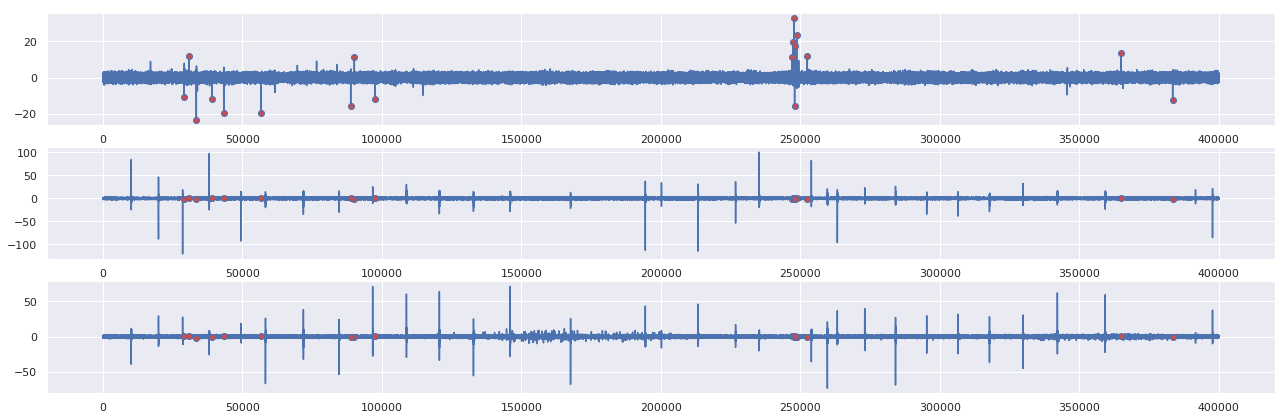

In [7]:
peaks_0 = prepare_peaks(cD_0)
peaks_1 = prepare_peaks(cD_1)
peaks_2 = prepare_peaks(cD_2)

%matplotlib inline
plt.figure(figsize=(22, 7))
plt.subplot(311)
plt.plot(cD_0, 'o', ls='-', markerfacecolor='r', markevery=peaks_0)
plt.subplot(312)
plt.plot(cD_1, 'o', ls='-', markerfacecolor='r', markevery=peaks_1)
plt.subplot(313)
plt.plot(cD_2, 'o', ls='-', markerfacecolor='r', markevery=peaks_2)
title = "SigMean: {:1.2}, Peaks: {}, Valleys: {}, Target: {}".format(sig_mean, len(peaks), len(valleys), target)
# plt.ylim([-50, 50])
plt.axis([0, len(cD_0), -50, 50])
plt.title(title, fontsize="28")
plt.show()

In [ ]:
pinfo.update({'peak_index': peaks})
dfp = pd.DataFrame(pinfo)

if 'peak_heights' in vinfo:
    vinfo.update({'peak_heights': -vinfo.get('peak_heights')})
vinfo.update({'peak_index': valleys})
dfv = pd.DataFrame(vinfo)

print(dfp.shape, dfv.shape)

df = pd.concat([dfp, dfv])
# print(df.shape)
# pp(df.columns)
# joblib.dump(df, './info_df.pkl')

In [ ]:
def within_ratio(h1, h2, ratio):
    """Check if h2 (height2) has the opposite sign of h1 (height1)
    and is smaller by an amount within the given ratio
    """
    resp = False
    if (h1 < 0 and h2 > 0) or (h1 > 0 and h2 < 0):
        if h1 < 0:
            if (h1 + h2) > ((1 - ratio) * h1):
                resp = True
        else:
            if (h1 + h2) < ((1 - ratio) * h1):
                resp = True
    return resp


def remove_symmetric_pulses(df, max_height, height_ratio, max_dist, max_peaks):
    for idx, row in df.iterrows():
        # if the next peak is the next index
        if (row.peak_index + 1) == df.iloc[idx + 1].peak_index:
            # and if the height is within height_ratio
            if within_ratio(row.peak_index, df.iloc[idx + 1].peak_index, 0.25):
                pass

In [ ]:
df.sort_values('peak_index', inplace=True)
df.reset_index(inplace=True, drop=True)